In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d sshikamaru/car-object-detection

100% 112M/112M [00:06<00:00, 24.3MB/s]
100% 112M/112M [00:06<00:00, 18.4MB/s]


In [3]:
import zipfile

zip_ref = zipfile.ZipFile('/content/car-object-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
!pip install imutils

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import io
import os
import random
import imutils
import warnings
warnings.filterwarnings('ignore')

In [6]:
file = pd.read_csv('/content/data/train_solution_bounding_boxes (1).csv')
file

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


In [7]:
file['label'] = 'car'
file

,image,xmin,ymin,xmax,ymax,label
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547,car
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180,car
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180,car
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575,car
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422,car
...,...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284,car
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895,car
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652,car
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864,car


In [8]:
data = []
target = []
filename = []

In [9]:
images_folder_path = '/content/data/training_images'

In [10]:
import tensorflow
from tensorflow.keras.preprocessing.image import img_to_array,load_img

In [11]:
for index,rows in file.iterrows():
  filenm, start_x, start_y, end_x, end_y, label = rows['image'], rows['xmin'], rows['ymin'], rows['xmax'], rows['ymax'], rows['label']

  filename.append(filenm)

  image_path = images_folder_path +'/'+ filenm

  image = cv2.imread(image_path)

  h,w,_ = image.shape

  start_x = start_x / w
  start_y = start_y / h
  end_x = end_x / w
  end_y = end_y / h

  image = load_img(image_path, target_size =(224, 224))
  image = img_to_array(image)

  data.append(image)
  target.append((start_x, start_y, end_x, end_y))

In [12]:
print(len(data))
print(len(target))
print(len(filename))

559
559
559


In [15]:
data=np.array(data,dtype="float32")/255.0     # convert the list to numpy array and then bring all pixel value between 0 to 1

targets=np.array(target,dtype="float32")

In [16]:
data.shape

(559, 224, 224, 3)

In [17]:
targets.shape

(559, 4)

In [18]:
from sklearn.model_selection import train_test_split

train_images, validation_images, train_targets, validation_targets = train_test_split(data, targets, test_size=0.1, random_state=2022)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

checkpoint_filepath = '/content/best_weights.hdf5'

earlyStop = EarlyStopping(monitor = 'val_accuracy', patience = 10, verbose = 1, mode = 'max', restore_best_weights = True)

In [20]:
checkpoint = ModelCheckpoint(filepath =checkpoint_filepath, save_weights_only =False,
                             monitor ='val_accuracy', mode ='max', sabe_best_only =True)

In [21]:
learningrate = ReduceLROnPlateau(monitor ='val_accuracy', mode= 'max', min_delta= 0.03, patientce =3,
                                 factor = 0.5, min_lr =0.00001, verbose =1)

In [22]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,Input
from tensorflow.keras.models import Model,Sequential

from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [23]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same', input_shape= (224,224,3)))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128, (3,3), activation= 'relu', padding= 'same'))
model.add(Conv2D(128, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(256, (3,3), activation= 'relu', padding= 'same'))
model.add(Conv2D(256, (3,3), activation= 'relu', padding= 'same'))

model.add(Flatten())
model.add(Dense(128, activation ='relu'))
model.add(Dense(64, activation ='relu'))
model.add(Dense(32, activation ='relu'))
model.add(Dense(16, activation ='relu'))
model.add(Dense(4, activation ='sigmoid'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

In [25]:
callbacks = [earlyStop, checkpoint, learningrate]

In [27]:
opt=Adam(learning_rate=0.0001)
model.compile(loss="mse",optimizer=opt, metrics=['accuracy'])

In [28]:
model.fit(train_images, train_targets, validation_data=(validation_images,validation_targets),
          batch_size=16, epochs=50, callbacks=callbacks, verbose=1)

Epoch 1/50
32/32 [==============================] - 21s 190ms/step - loss: 0.0506 - accuracy: 0.4712 - val_loss: 0.0506 - val_accuracy: 0.6429 - lr: 1.0000e-04
Epoch 2/50
32/32 [==============================] - 5s 146ms/step - loss: 0.0490 - accuracy: 0.5726 - val_loss: 0.0511 - val_accuracy: 0.5179 - lr: 1.0000e-04
Epoch 3/50
32/32 [==============================] - 6s 176ms/step - loss: 0.0491 - accuracy: 0.5567 - val_loss: 0.0502 - val_accuracy: 0.6429 - lr: 1.0000e-04
Epoch 4/50
32/32 [==============================] - 4s 140ms/step - loss: 0.0479 - accuracy: 0.5706 - val_loss: 0.0478 - val_accuracy: 0.6429 - lr: 1.0000e-04
Epoch 5/50
32/32 [==============================] - 5s 158ms/step - loss: 0.0436 - accuracy: 0.6561 - val_loss: 0.0367 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 6/50
32/32 [==============================] - 5s 156ms/step - loss: 0.0361 - accuracy: 0.7316 - val_loss: 0.0335 - val_accuracy: 0.8214 - lr: 1.0000e-04
Epoch 7/50
32/32 [===========================

In [29]:
model.save('/content/best_weights.hdf5')

In [30]:
model = load_model('/content/best_weights.hdf5')

1/1 [==============================] - 0s 21ms/step
380 676
1/1 [==============================] - 0s 25ms/step
380 676
1/1 [==============================] - 0s 18ms/step
380 676
1/1 [==============================] - 0s 21ms/step
380 676
1/1 [==============================] - 0s 19ms/step
380 676
1/1 [==============================] - 0s 27ms/step
380 676
1/1 [==============================] - 0s 20ms/step
380 676
1/1 [==============================] - 0s 21ms/step
380 676
1/1 [==============================] - 0s 22ms/step
380 676
1/1 [==============================] - 0s 21ms/step
380 676
1/1 [==============================] - 0s 42ms/step
380 676
1/1 [==============================] - 0s 26ms/step
380 676
1/1 [==============================] - 0s 30ms/step
380 676
1/1 [==============================] - 0s 27ms/step
380 676
1/1 [==============================] - 0s 36ms/step
380 676
1/1 [==============================] - 0s 29ms/step
380 676
1/1 [==============================] - 0

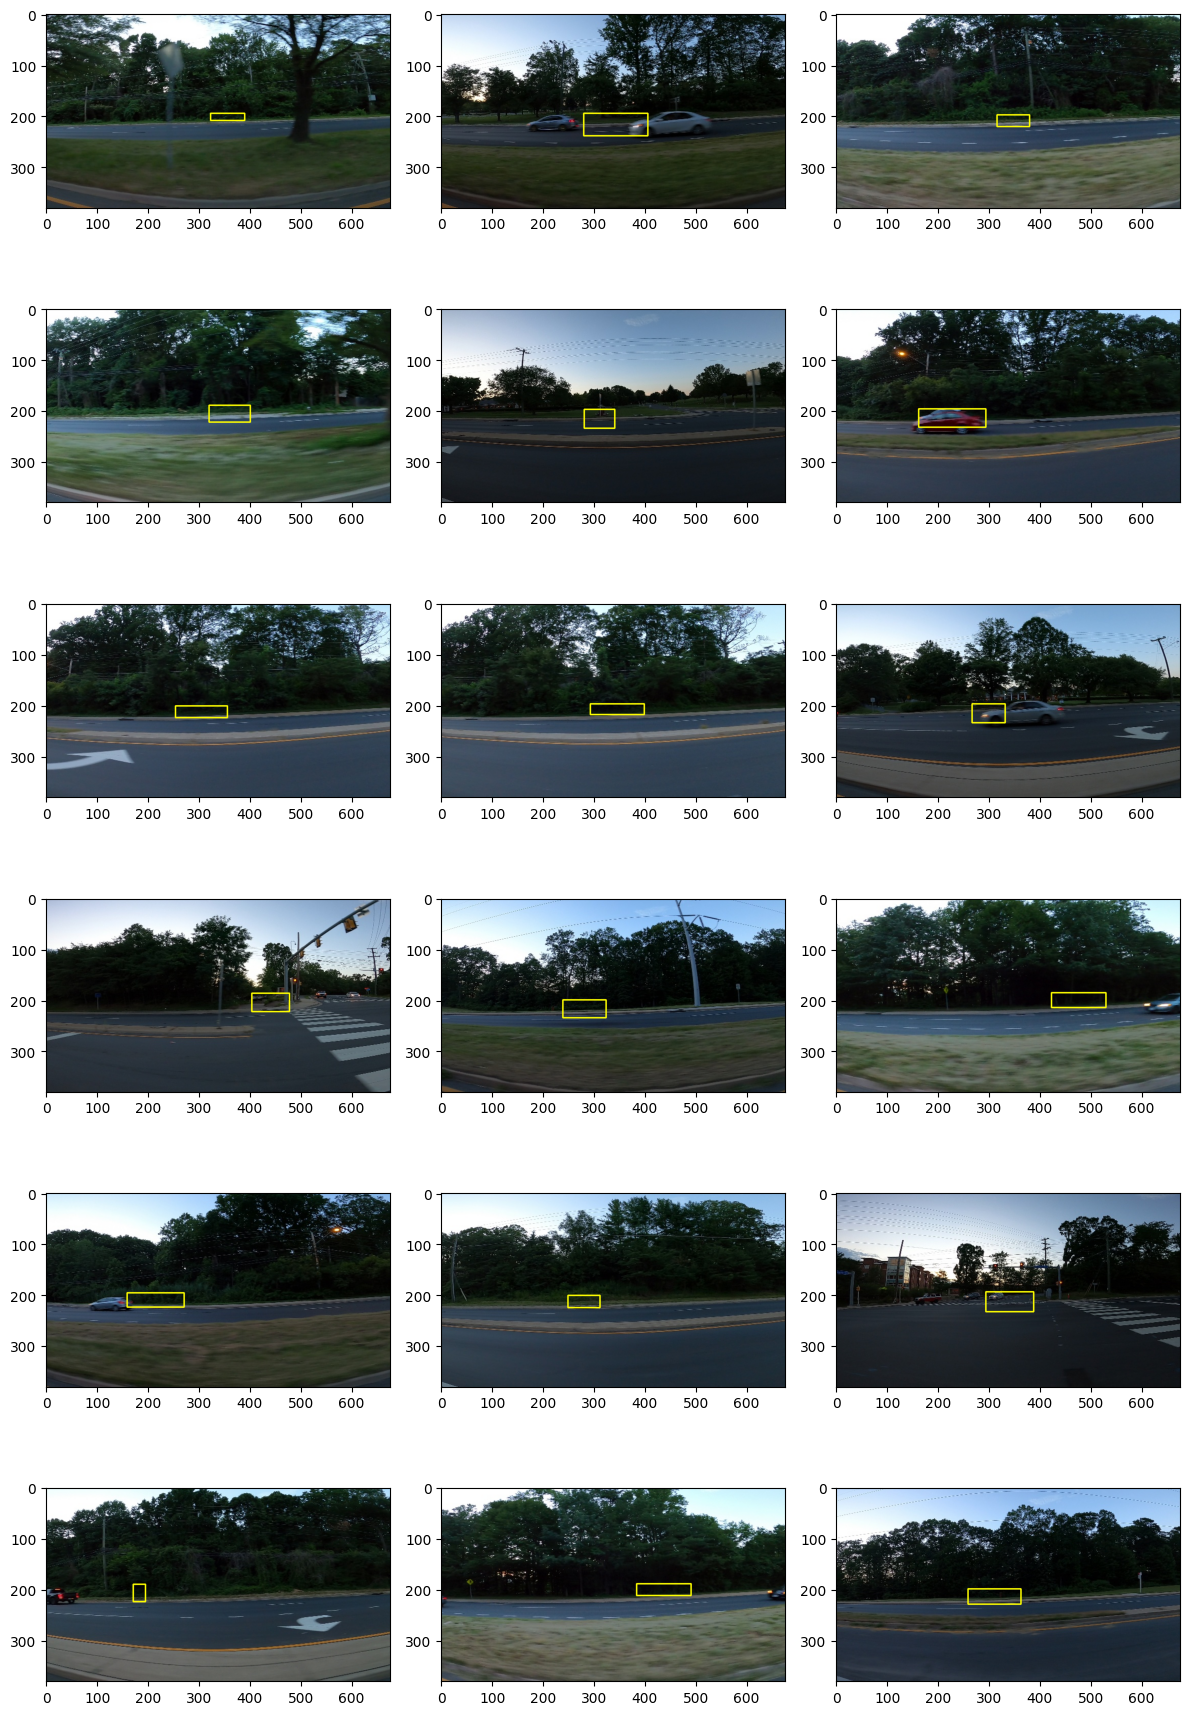

In [33]:
plt.figure(figsize= (12,18))

test_images_folder_path = '/content/data/testing_images/'

test_image_path = os.listdir(test_images_folder_path)

test_image_path = [test_images_folder_path + i for i in test_image_path]

for index, path in enumerate(test_image_path[0:18]):
  test_image = load_img(path, target_size=(224,224))
  test_image = np.array(test_image) / 255
  test_image =np.expand_dims(test_image, axis= 0)

  prediction = model.predict(test_image)[0]

  (startX, startY, endX, endY) = prediction

  test_img = cv2.imread(path)
  test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

  (h,w) = test_img.shape[:2]
  # print(h , w)
  startX = int(startX * w)
  startY = int(startY * h)
  endX = int(endX * w)
  endY = int(endY * h)

  cv2.rectangle(test_img, (startX,startY), (endX, endY), (255,255,0), 2)
  plt.subplot(6, 3, index+1)
  plt.imshow(test_img)

plt.tight_layout()
plt.show()

In [34]:
import imgaug.augmenters as iaa

    # Define the Cutout augmentation
cutout = iaa.Cutout(nb_iterations=5, size=0.1, squared=False)

    # Apply the augmentation to the training set
X_train_augmented = np.empty_like(train_images)
for i, image in enumerate(train_images):
    X_train_augmented[i] = cutout.augment_image(image)

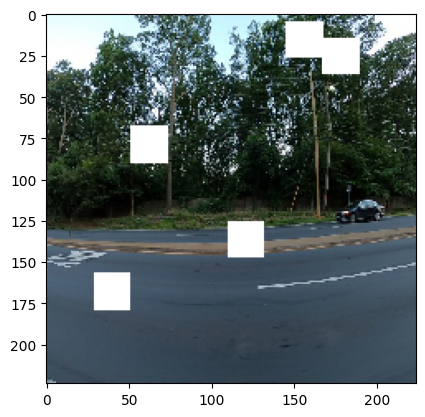

In [36]:
plt.imshow(X_train_augmented[9])
plt.show()

In [37]:
model_2=Sequential()
model_2.add(Conv2D(64,(3,3),activation="relu",padding="same",input_shape=(224,224,3)))
model_2.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model_2.add(MaxPool2D(2,2))
model_2.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model_2.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model_2.add(MaxPool2D(2,2))
model_2.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model_2.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model_2.add(MaxPool2D(2,2))
model_2.add(Conv2D(512,(3,3),activation="relu",padding="same"))
model_2.add(Conv2D(512,(3,3),activation="relu",padding="same"))
model_2.add(Flatten())
model_2.add(Dense(256,activation="relu"))
model_2.add(Dense(128,activation="relu"))
model_2.add(Dense(64,activation="relu"))
model_2.add(Dense(32,activation="relu"))
model_2.add(Dense(4,activation="sigmoid"))


opt=Adam(learning_rate=0.0001)
model_2.compile(loss="mse",optimizer=opt, metrics=['accuracy'])

In [39]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [40]:
model_2.fit(X_train_augmented, train_targets, validation_data = (validation_images,validation_targets), batch_size=16,
            epochs=50,callbacks=callbacks,verbose=1)

Epoch 1/50
32/32 [==============================] - 31s 646ms/step - loss: 0.0556 - accuracy: 0.5229 - val_loss: 0.0572 - val_accuracy: 0.6429 - lr: 1.0000e-04
Epoch 2/50
32/32 [==============================] - 13s 427ms/step - loss: 0.0465 - accuracy: 0.6064 - val_loss: 0.0574 - val_accuracy: 0.6429 - lr: 1.0000e-04
Epoch 3/50
32/32 [==============================] - 23s 750ms/step - loss: 0.0395 - accuracy: 0.6899 - val_loss: 0.0574 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 4/50
32/32 [==============================] - 18s 575ms/step - loss: 0.0270 - accuracy: 0.7594 - val_loss: 0.0575 - val_accuracy: 0.1607 - lr: 1.0000e-04
Epoch 5/50
32/32 [==============================] - 14s 438ms/step - loss: 0.0162 - accuracy: 0.8012 - val_loss: 0.0573 - val_accuracy: 0.6429 - lr: 1.0000e-04
Epoch 6/50
32/32 [==============================] - 18s 566ms/step - loss: 0.0108 - accuracy: 0.8588 - val_loss: 0.0574 - val_accuracy: 0.6429 - lr: 1.0000e-04
Epoch 7/50
32/32 [======================

In [41]:
model_2.save('/content/best_weights_two.hdf5')

In [43]:
test_loss, test_acc = model.evaluate(validation_images, validation_targets)

print(test_loss)
print(test_acc)

2/2 [==============================] - 3s 1s/step - loss: 0.0322 - accuracy: 0.8393
0.03218870609998703
0.8392857313156128


In [44]:
test_loss2, test_acc2 = model_2.evaluate(validation_images, validation_targets)

print(test_loss2)
print(test_acc2)

2/2 [==============================] - 8s 3s/step - loss: 0.0572 - accuracy: 0.6429
0.05717449262738228
0.6428571343421936
